# Notes - maternal age


In [7]:
import duckdb
import os
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from chance import get_ds_lb_nt_probability_array
from graphviz import Digraph
from sympy.physics.units import magnetic_density

from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

In [8]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [9]:
MIN_YEAR = 2004
MAX_YEAR = 2024

In [18]:
counts_df = con.execute(
    f"""
        SELECT
            year as time,
            mage_c as age,
            count(mage_c) as observed,
            SUM(down_ind) as ds_recorded
        FROM
            us_births
        WHERE
            year >= {MIN_YEAR} AND year <= {MAX_YEAR}
        GROUP BY year, mage_c
        ORDER BY year, mage_c
        """
).df()
counts_df

,time,age,observed,ds_recorded
0,2004,12,188,0.0
1,2004,13,1075,0.0
2,2004,14,5522,0.0
3,2004,15,18301,10.0
4,2004,16,41918,13.0
...,...,...,...,...
814,2024,46,2455,16.0
815,2024,47,1410,10.0
816,2024,48,788,2.0
817,2024,49,632,1.0


In [19]:
age = np.asarray(counts_df["age"], dtype=np.int64)
observed = np.asarray(counts_df["observed"], dtype=np.int64)
ds_recorded = np.asarray(counts_df["ds_recorded"], dtype=np.int64)

In [21]:

with pm.Model() as model:
    age_data = pm.Data("age", age)

    c = pm.Normal("c", mu=37.23, sigma=5.0)
    k = pm.Normal("k", mu=0.2815, sigma=0.1)

    inner = pm.math.sigmoid(k * (age_data - c))

    beta0 = pm.Normal("beta0", mu=-7.33, sigma=2.0)
    beta1 = pm.Normal("beta1", mu=4.211, sigma=2.0)

    eta = beta0 + beta1 * inner
    r   = pm.Deterministic("r", pm.math.sigmoid(eta))

    y_obs = pm.Binomial("y_obs", n=observed, p=r, observed=ds_recorded)

Free random variables: [c, k, beta0, beta1]
Observed random variables: [y_obs]


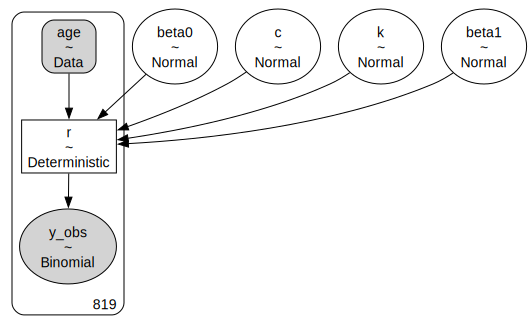

In [22]:
print(f"Free random variables: {model.free_RVs}")
print(f"Observed random variables: {model.observed_RVs}")

# set font for model graph

graph = pm.model_to_graphviz(model)
graph.graph_attr["fontname"] = "Helvetica"
graph.node_attr["fontname"] = "Helvetica"
graph.edge_attr["fontname"] = "Helvetica"
graph

In [35]:
with model:
    idata_prior = pm.sample_prior_predictive(
        samples=1000,
        var_names=["c", "k", "beta0", "beta1", "r", "y_obs"],
    )

Sampling: [beta0, beta1, c, k, y_obs]


In [77]:
r_prior = idata_prior.prior["r"]
r_mean = r_prior.mean()
r_hdi  = az.hdi(r_prior)
r_prior

<xarray.DataArray 'r' (chain: 1, draw: 1000, r_dim_0: 819)> Size: 7MB
array([[[1.22876456e-02, 1.23439015e-02, 1.24246843e-02, ...,
         8.23733293e-01, 8.24091325e-01, 8.24341384e-01],
        [3.79036439e-03, 3.79373417e-03, 3.79814003e-03, ...,
         4.53741011e-02, 4.68672351e-02, 4.80694024e-02],
        [7.64312630e-05, 7.65554066e-05, 7.67314047e-05, ...,
         2.85237408e-02, 2.87955792e-02, 2.89896327e-02],
        ...,
        [5.60904035e-02, 5.75832531e-02, 5.93215051e-02, ...,
         8.89824437e-01, 9.01499795e-01, 9.11193796e-01],
        [1.49022626e-03, 1.49026494e-03, 1.49031645e-03, ...,
         8.58396578e-03, 1.27531256e-02, 1.97558594e-02],
        [2.46303650e-04, 2.46988361e-04, 2.47943736e-04, ...,
         1.46788129e-02, 1.47429640e-02, 1.47892751e-02]]],
      shape=(1, 1000, 819))
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * r_dim_0  (r_dim_0) int64 7kB 0 1 2 3 4 5 6 7 ... 812 813 814 815 816 817 818

ValueError: x and y must have same first dimension, but have shapes (819,) and (1,)

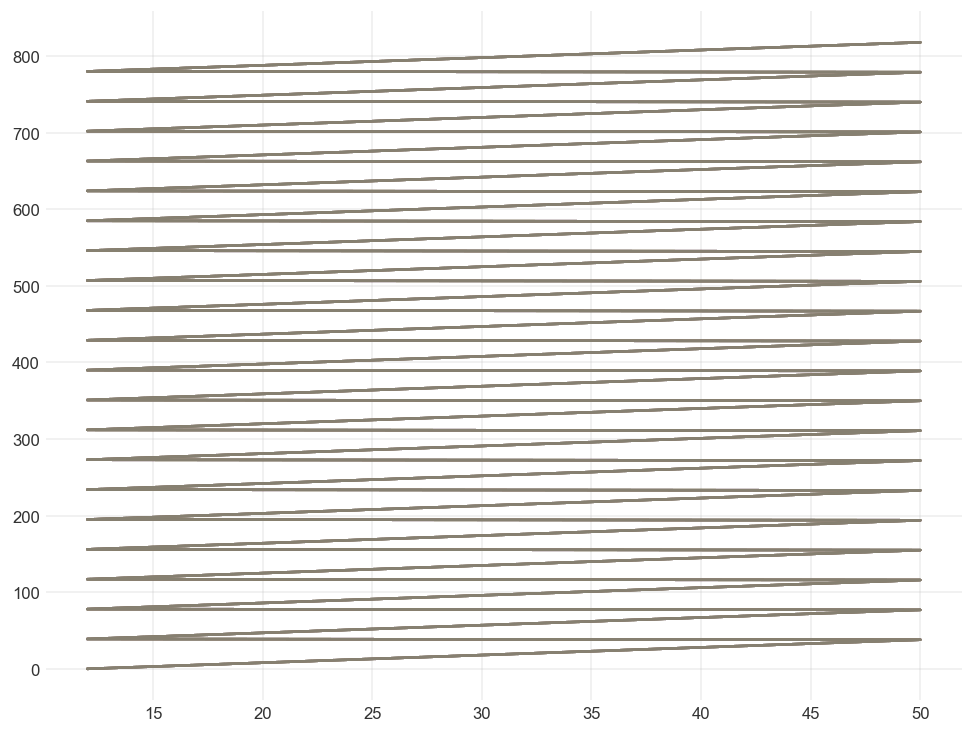

In [75]:


for i in range(50):
    plt.plot(age, r_prior["r_dim_0"], alpha=0.1)

# mean and 90% band
plt.plot(age, r_mean, lw=2, label="prior mean r(age)")
plt.fill_between(age, r_hdi["higher"], r_hdi["lower"], alpha=0.3, label="90% prior band")

plt.xlabel("Age")
plt.ylabel("Probability r(age)")
plt.legend()
plt.title("Prior predictive for r(age)")

ValueError: x and y must have same first dimension, but have shapes (819,) and (1000, 819)

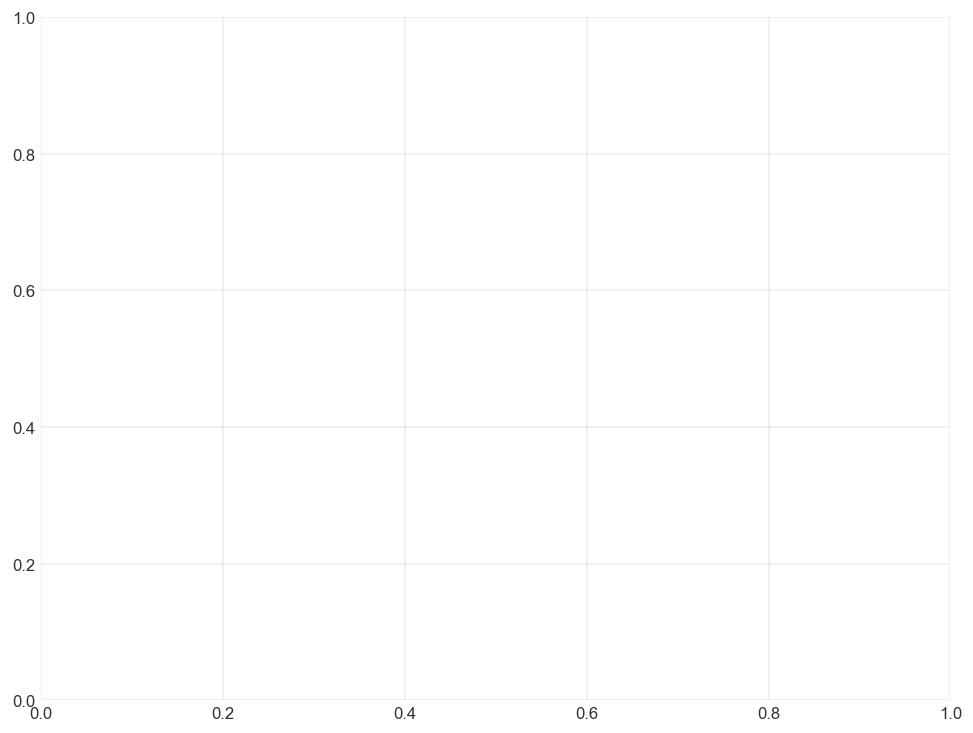

In [50]:
for i in range(50):
    plt.plot(age, r_prior[i, :], alpha=0.1)

# mean and 90% band
plt.plot(age, r_mean, lw=2, label="prior mean r(age)")
plt.fill_between(age, r_hdi[:, 0], r_hdi[:, 1], alpha=0.3, label="90% prior band")

plt.xlabel("Age")
plt.ylabel("Probability r(age)")
plt.legend()
plt.title("Prior predictive for r(age)")

In [23]:
with model:
    idata = pm.sample(
        2000,
        tune=2000,
        target_accept=0.8,
        return_inferencedata=True,
        random_seed=RANDOM_SEED,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, k, beta0, beta1]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [24]:
az.summary(idata, var_names=["c", "k", "beta0", "beta1", "r"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,37.529,0.069,37.399,37.657,0.001,0.001,3514.0,4081.0,1.0
k,0.358,0.007,0.346,0.370,0.000,0.000,2842.0,3659.0,1.0
beta0,-8.281,0.011,-8.300,-8.260,0.000,0.000,3485.0,4075.0,1.0
beta1,3.254,0.035,3.191,3.321,0.001,0.001,2652.0,2898.0,1.0
r[0],0.000,0.000,0.000,0.000,0.000,0.000,3495.0,4086.0,1.0
...,...,...,...,...,...,...,...,...,...
r[814],0.006,0.000,0.005,0.006,0.000,0.000,3297.0,4329.0,1.0
r[815],0.006,0.000,0.006,0.006,0.000,0.000,3154.0,4186.0,1.0
r[816],0.006,0.000,0.006,0.006,0.000,0.000,3068.0,4010.0,1.0
r[817],0.006,0.000,0.006,0.006,0.000,0.000,3012.0,3887.0,1.0


In [25]:
with model:
    prior_idata = pm.sample_prior_predictive()

Sampling: [beta0, beta1, c, k, y_obs]


<Axes: xlabel='y_obs'>

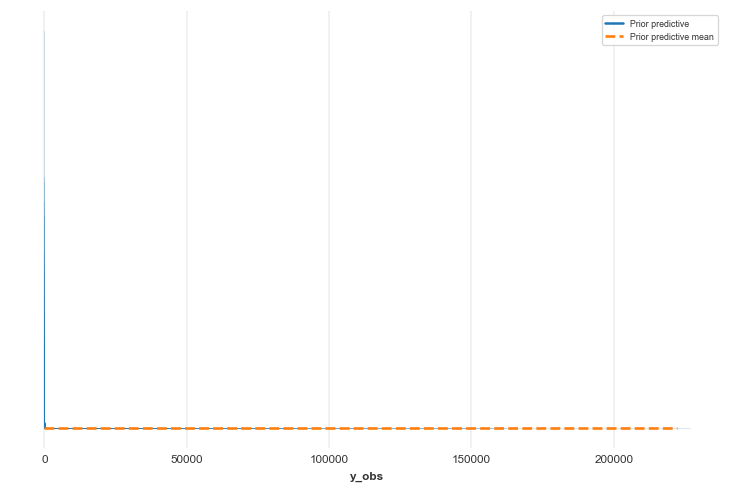

In [26]:
az.plot_ppc(
    prior_idata,
    group="prior",
    num_pp_samples=400,
    figsize=(6, 4),
    random_seed=RANDOM_SEED,
)

array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

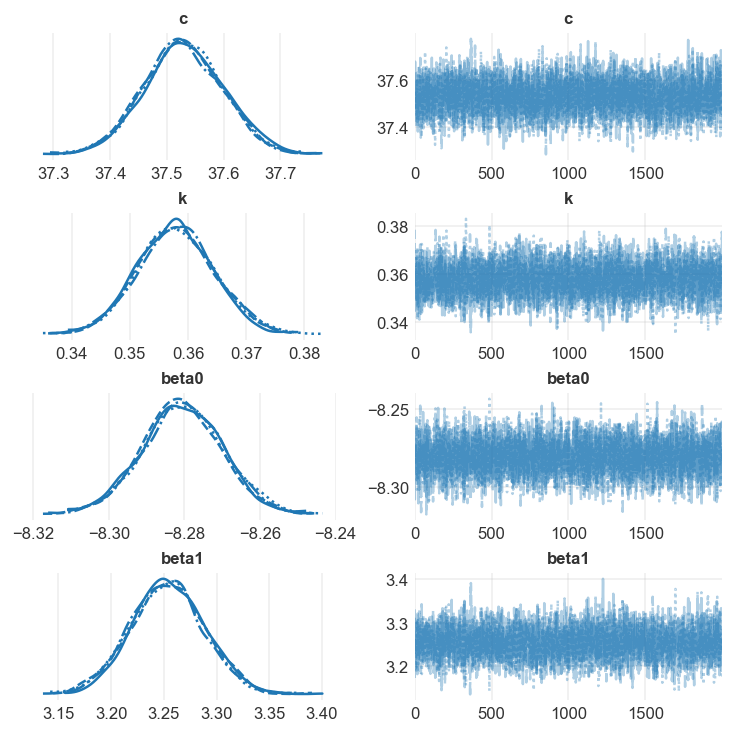

In [27]:
az.plot_trace(idata, var_names=["c", "k", "beta0", "beta1"], figsize=(6, 6))

array([<Axes: title={'center': 'c'}>, <Axes: title={'center': 'k'}>,
       <Axes: title={'center': 'beta0'}>,
       <Axes: title={'center': 'beta1'}>], dtype=object)

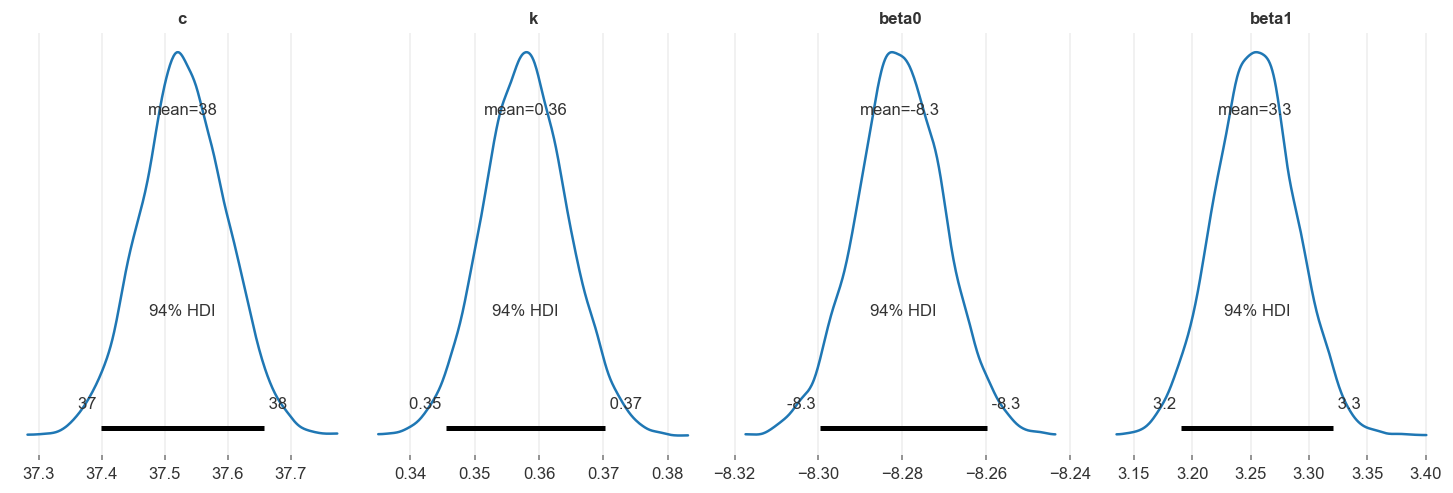

In [28]:
az.plot_posterior(
    idata, var_names=["c", "k", "beta0", "beta1"], figsize=(12, 4)
)

<Axes: >

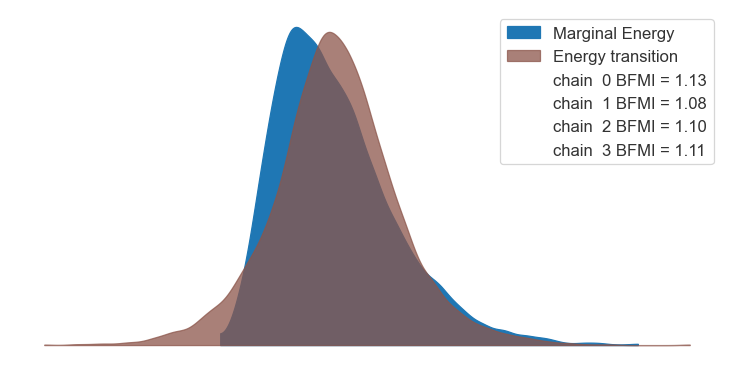

In [29]:
az.plot_energy(idata, figsize=(6, 3))

In [30]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs"])

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

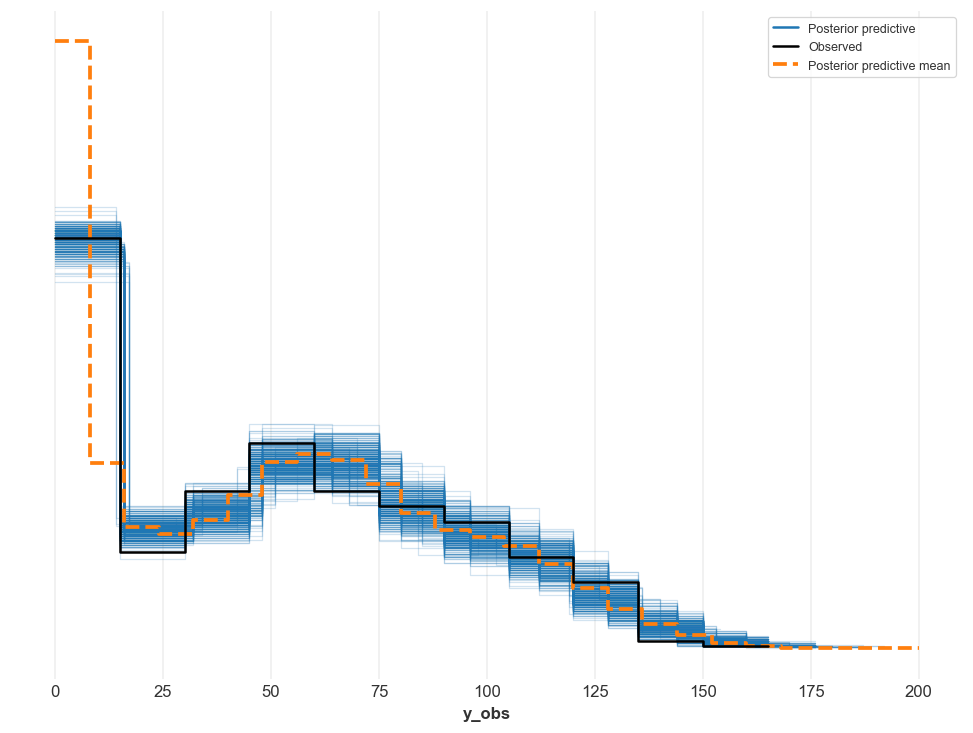

In [31]:
az.plot_ppc(ppc, num_pp_samples=400, random_seed=RANDOM_SEED, figsize=(8, 6))

<Axes: xlabel='y_obs'>

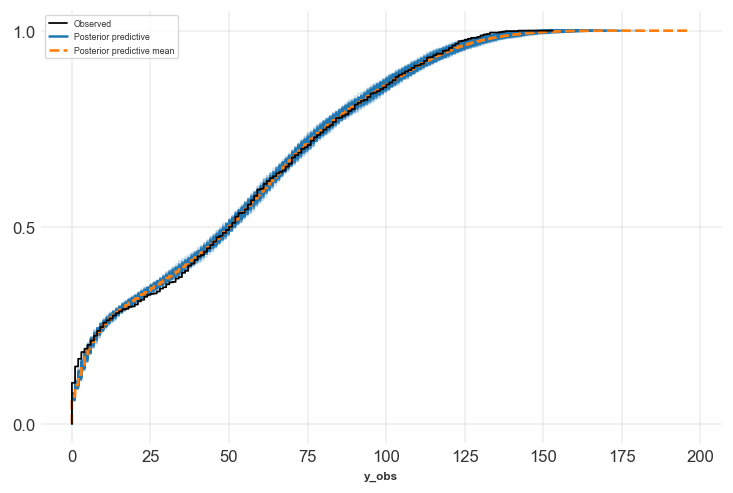

In [32]:
az.plot_ppc(ppc, num_pp_samples=200, kind="cumulative", random_seed=RANDOM_SEED, figsize=(6, 4))

In [34]:
# Posterior predictive draws: shape (chain, draw, obs)
y_ppc = ppc.posterior_predictive["y_obs"]

y_mean = y_ppc.mean(dim=("chain", "draw"))

hdi = az.hdi(y_ppc, hdi_prob=0.95)
lower = hdi.sel(hdi="lower")
upper = hdi.sel(hdi="higher")

# Sort indices by age
order = np.argsort(age)
x_sorted = age[order]
y_obs_sorted = ds_recorded[order]
y_mean_sorted = y_mean.values[order]
lower_sorted = lower["y_obs"][order]
upper_sorted = upper["y_obs"][order]


In [ ]:
# m: posterior samples of the mean probability per observation
# dims typically: ("chain", "draw", "age") or ("chain", "draw", "m_dim_0")
m_post = idata.posterior["m"]

# Convert to latent expected *score* (mean of Y given parameters)
score_post = m_post * n_max   # broadcast over chain/draw/obs

# Posterior mean latent score per observation
score_mean = score_post.mean(dim=("chain", "draw"))

# 95% HDI for latent mean score per observation
score_hdi = az.hdi(score_post, hdi_prob=0.95)

m_lower = score_hdi.sel(hdi="lower")
m_upper = score_hdi.sel(hdi="higher")

score_mean_sorted  = score_mean.values[order]
m_lower_sorted = m_lower["m"][order]
m_upper_sorted = m_upper["m"][order]
